# Metropolis-Hastings MCMC with Adaptive (Dynamical) Proposal Covariance

This notebook demonstrates a Metropolis-Hastings MCMC for non-flat ΛCDM cosmology with a "dynamically updating" proposal covariance matrix. After the burn-in phase which uses the initial proposal covariance matrix, every `adapt_interval`steps the proposal is updated (_i.e._ while the chains _is running_). One the counter reaches `adapt_interval` I calculate the empirical covariance `emp_cov` based on the previous samples and use it as the new proposal distribution for the next `adapt_interal` and repeat. 

<Note> The chains run _sequentially_ thus I do not need to calculate separate proposal matrices there's just one that keeps changing and restets when a chian ends and the for-cycle starts the next one! 

In [1]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyACC.cosmology.cosmology import LambdaCDM
from pyACC.cosmology.distances import  CosmologicalDistances

## Data Loading (DESI + CMB)

In [2]:
# DESI data
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)
z = data["z_eff"].values
D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values

# CMB means and covariance (Planck, as in previous notebooks)
theta_star_mean = 1.04097/100
w_b_mean = 0.02223
w_bc_mean = 0.14208
Neff = 3.046
cmb_means = np.array([theta_star_mean, w_b_mean, w_bc_mean])
cmb_cov = np.array([
    [0.006621e-9, 0.12444e-9, -1.1929e-9],
    [0.12444e-9, 21.344e-9, -94.001e-9],
    [-1.1929e-9, -94.001e-9, 1488.4e-9]
])
cmb_cov_inv = np.linalg.inv(cmb_cov)

def r_d(w_b, w_bc, Neff=3.046):
    return 147.05 * (w_b/0.02236)**(-0.13) * (w_bc/0.1432)**(-0.23) * (Neff/3.046)**(-0.1)

r_d_val = r_d(w_b_mean, w_bc_mean, Neff)

## Log-Likelihood for non-flat ΛCDM (Omega_Lambda parameterization)

In [3]:
def model_cmb_params(H0):
    return np.array([theta_star_mean, w_b_mean, w_bc_mean])

def log_likelihood(params):
    H0, Omega_m, Omega_Lambda = params
    # Physical priors
    if not (50 < H0 < 80 and 0 < Omega_m < 1 and 0 < Omega_Lambda < 1):
        return -np.inf
    Omega_k = 1.0 - Omega_m - Omega_Lambda
    model = LambdaCDM(H0, Omega_m, Omega_Lambda, Omega_radiation=0.0)
    D_V_model = np.array([CosmologicalDistances(model.H).volume_distance(z_i) for z_i in z])
    chi2_desi = np.sum(((D_V_obs - D_V_model / r_d_val) / D_V_err) ** 2)
    cmb_model = model_cmb_params(H0)
    delta = cmb_model - cmb_means
    chi2_cmb = delta @ cmb_cov_inv @ delta
    return -0.5 * (chi2_desi + chi2_cmb)

## Multiple Metropolis-Hastings Chains with Adaptive Proposal

In [4]:
nMH = 10             # Number of independent M-H chains
nsteps = 100000      # Steps per chain
burnin = 10000

# Parameter space bounds for random starts
H0_bounds = (60, 75)
Om_bounds = (0, 1)
OL_bounds = (0, 1)

rng = np.random.default_rng(42)
chains = np.zeros((nMH, nsteps, 3))

# Initial proposal covariance 
proposal_cov = np.diag([0.03, 0.002, 0.002])
adapt_start = 1000                      # Start adapting after this many steps so I do not waste computational power in the burnin phase
adapt_interval = 500                    # Update proposal every this many steps

adapt_scale = 2.38**2 / 3               # Optimal scaling for multivariate normal (Gelman et al.)
                                        #2.38 magical number that optimizes the acceptance rate for multivariate normal proposals
                                        #over the number of dof (i.e. 3)


for c in range(nMH): # Loop over (hopefully) independent chains
    
    # Randomly initialize parameters within bounds
    H0_0 = rng.uniform(*H0_bounds)
    Om_0 = rng.uniform(*Om_bounds)
    OL_0 = rng.uniform(*OL_bounds)
    params_init = np.array([H0_0, Om_0, OL_0])

    # Initialize chain with the first sample
    chains[c, 0] = params_init 
    logp = log_likelihood(params_init)
    chain_samples = [params_init]
    

    for i in range(1, nsteps):
        # Dynamically update proposal covariance after adapt_start and every adapt_interval steps
        if i > adapt_start and i % adapt_interval == 0:
            recent = np.array(chain_samples[max(0, i-5000):i])
            if recent.shape[0] > 10:
                emp_cov = np.cov(recent, rowvar=False)
                proposal_cov = adapt_scale * (emp_cov + 1e-6 * np.eye(3))
        proposal = rng.multivariate_normal(chains[c, i-1], proposal_cov)
        logp_prop = log_likelihood(proposal)
        if np.log(rng.uniform()) < logp_prop - logp:
            chains[c, i] = proposal
            logp = logp_prop
        else:
            chains[c, i] = chains[c, i-1]
         
            
        chain_samples.append(chains[c, i])

In [5]:
param_labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"]

# Ensure 'samples' is defined ()
if 'samples' not in locals():
    samples = np.concatenate([chains[c, burnin:] for c in range(nMH)], axis=0)

# Print posterior means and 1-sigma errors for all parameters after burn-in
means = np.mean(samples, axis=0)
stds = np.std(samples, axis=0)
for i, (mean, std) in enumerate(zip(means, stds)):
    print(f"Posterior mean for {param_labels[i]}: {mean:.4f} ± {std:.4f} (1-sigma)")

Posterior mean for $H_0$: 67.7494 ± 1.3048 (1-sigma)
Posterior mean for $\Omega_m$: 0.2677 ± 0.0352 (1-sigma)
Posterior mean for $\Omega_\Lambda$: 0.6143 ± 0.0932 (1-sigma)


## Convergence Diagnostics: Gelman-Rubin $\hat{R}$ and Effective Sample Size (ESS)

In [6]:
# Discard burn-in and concatenate all chains for posterior analysis
samples = np.concatenate([chains[c, burnin:] for c in range(nMH)], axis=0)

def gelman_rubin_multi(chains, burnin=0):
    # chains: (nMH, nsteps, ndim)
    nMH, nsteps, ndim = chains.shape
    Rhat = np.zeros(ndim)
    for k in range(ndim):
        chain_k = chains[:, burnin:, k]
        mean_per_chain = np.mean(chain_k, axis=1)
        var_per_chain = np.var(chain_k, axis=1, ddof=1)
        B = nsteps * np.var(mean_per_chain, ddof=1)
        W = np.mean(var_per_chain)
        var_hat = (1 - 1/nsteps) * W + B / nsteps
        Rhat[k] = np.sqrt(var_hat / W)
    return Rhat

Rhat = gelman_rubin_multi(chains, burnin=burnin)
param_labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
for i, r in enumerate(Rhat):
    print(f"R-hat for {param_labels[i]}: {r:.6f} {'(converged)' if r < 1.01 else '(NOT converged)'}")

def autocorr_time(chain, max_lag=100):
    n, ndim = chain.shape
    act = np.empty(ndim)
    for k in range(ndim):
        x = chain[:, k] - np.mean(chain[:, k])
        acf = np.correlate(x, x, mode='full')[n-1:] / np.arange(n, 0, -1)
        acf /= acf[0]
        positive = acf[:max_lag][acf[:max_lag] > 0]
        act[k] = 1 + 2 * np.sum(positive[1:])
    return act

tau = autocorr_time(samples)
ESS = samples.shape[0] / tau
for i, ess in enumerate(ESS):
    print(f"ESS for {param_labels[i]}: {ess:.1f}")

R-hat for $H_0$: 1.000058 (converged)
R-hat for $\Omega_m$: 1.000108 (converged)
R-hat for $\Omega_\Lambda$: 1.000073 (converged)
ESS for $H_0$: 76816.0
ESS for $\Omega_m$: 78603.8
ESS for $\Omega_\Lambda$: 76782.4


## Chain Evolution: Trace Plots and 2D Projections

Below, you can visualize the evolution of each MCMC chain:

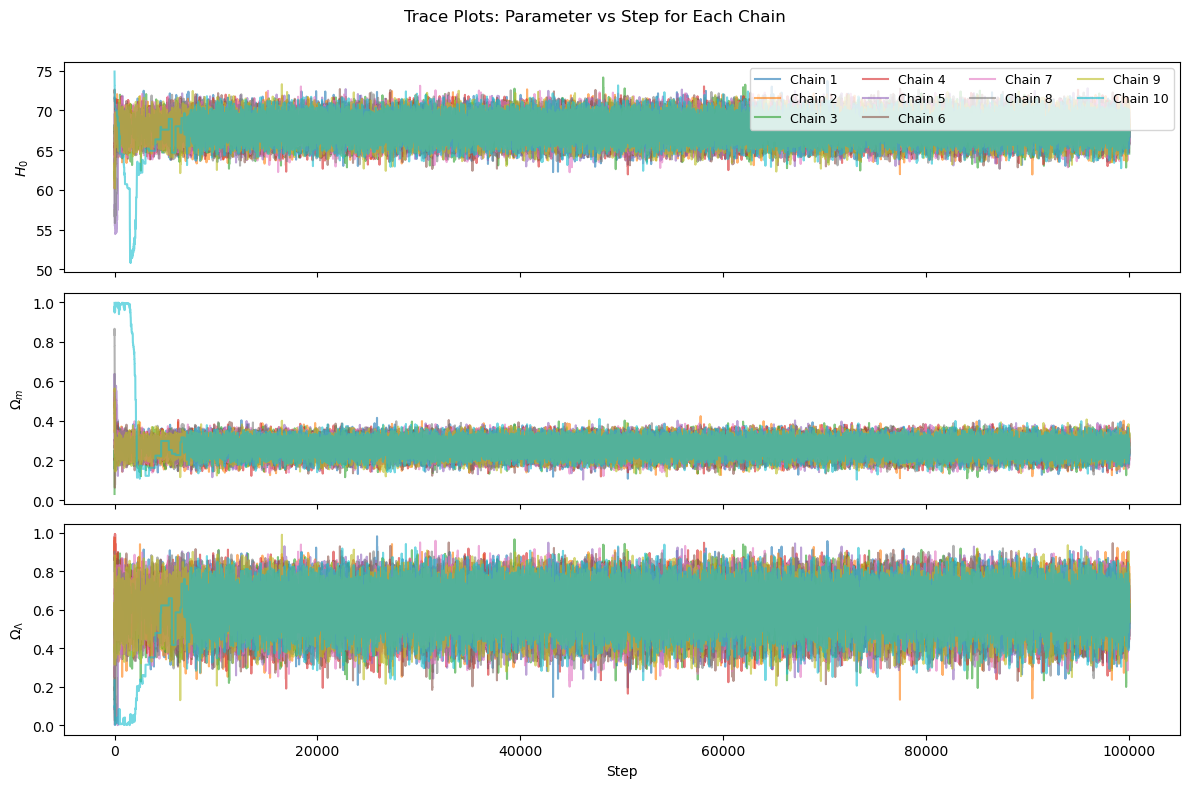

In [7]:
# Trace plots: parameter vs step for each chain
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for c in range(nMH):
    for k in range(3):
        axes[k].plot(chains[c, :, k], alpha=0.6, label=f'Chain {c+1}' if k==0 else None)
for k, ax in enumerate(axes):
    ax.set_ylabel(param_labels[k])
axes[-1].set_xlabel('Step')
axes[0].legend(loc='upper right', ncol=4, fontsize=9)
fig.suptitle('Trace Plots: Parameter vs Step for Each Chain')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

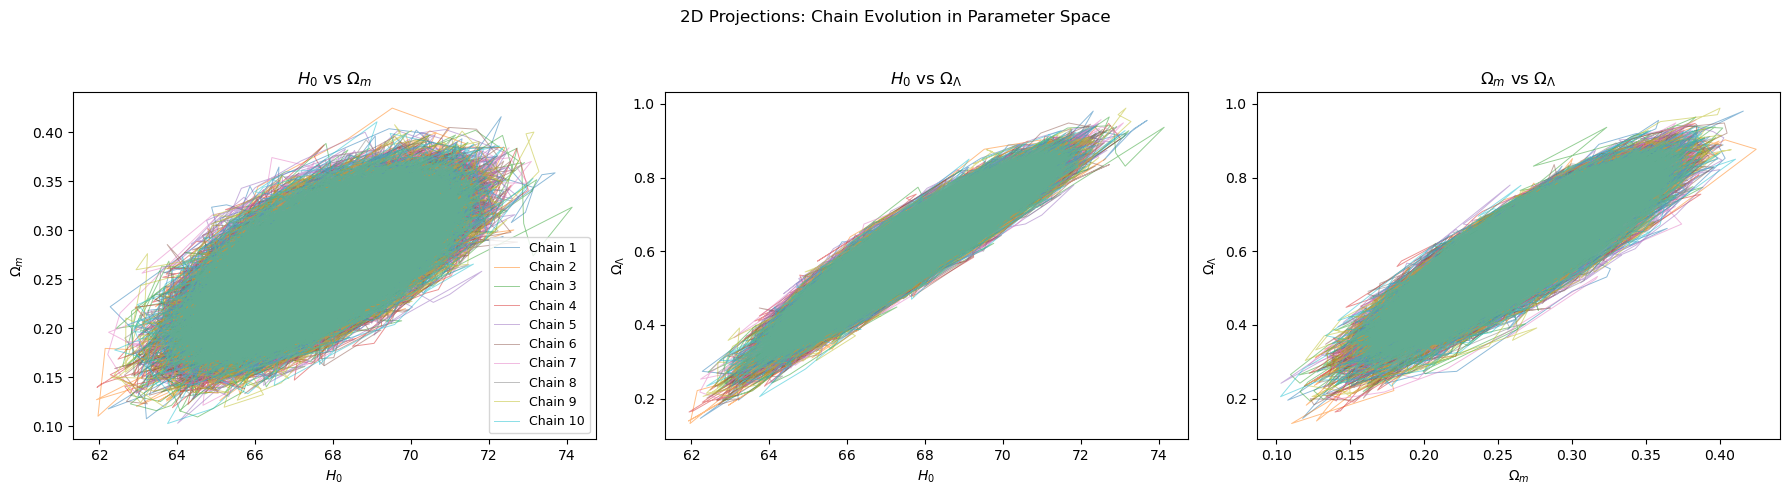

In [8]:
# 2D projections: parameter space evolution for all pairs (no 3D)
from itertools import combinations
pairs = list(combinations(range(3), 2))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    for c in range(nMH):
        ax.plot(chains[c, burnin:, i], chains[c, burnin:, j], alpha=0.5, lw=0.7, label=f'Chain {c+1}' if idx==0 else None)
    ax.set_xlabel(param_labels[i])
    ax.set_ylabel(param_labels[j])
    ax.set_title(f'{param_labels[i]} vs {param_labels[j]}')
if nMH > 1:
    axes[0].legend(loc='best', fontsize=9)
fig.suptitle('2D Projections: Chain Evolution in Parameter Space')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

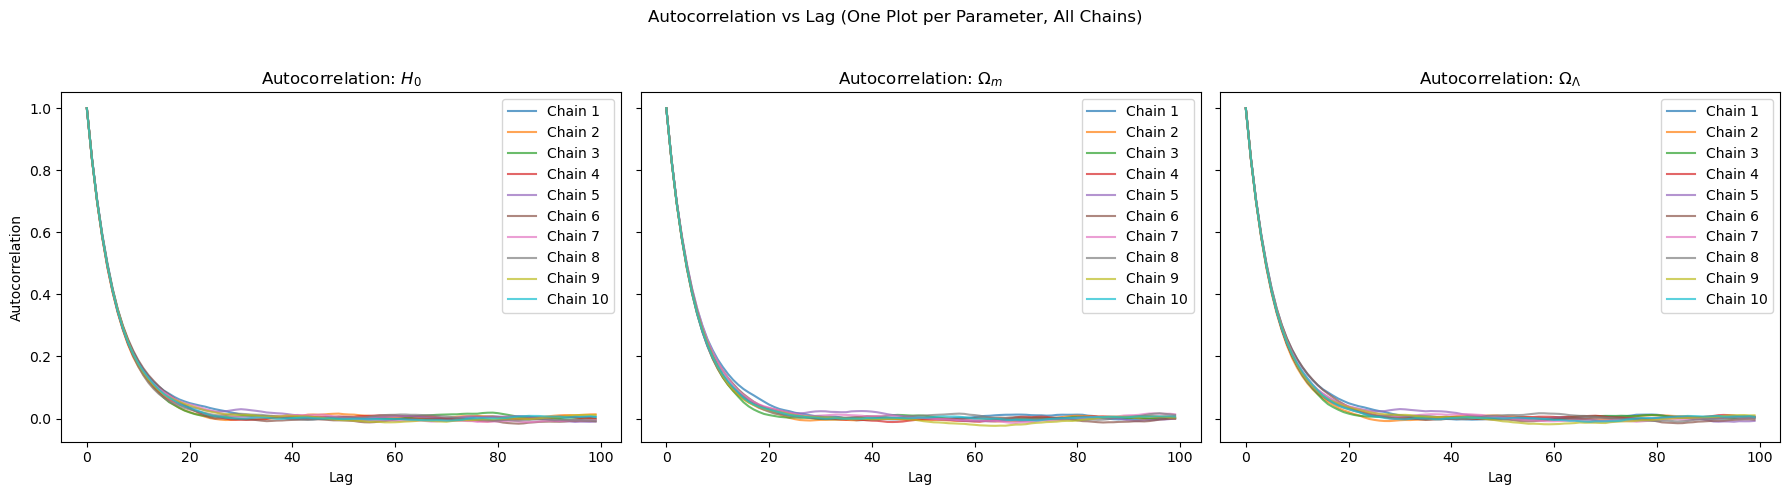

In [9]:
# Autocorrelation vs lag: one plot per parameter, all chains overlaid (plain python)
def autocorr_func_1d(x, max_lag=100):
    n = len(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')[n-1:]
    result /= result[0]
    return result[:max_lag]

max_lag = 100
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for k in range(3):
    for c in range(nMH):
        acf = autocorr_func_1d(chains[c, burnin:, k], max_lag=max_lag)
        axes[k].plot(np.arange(max_lag), acf, alpha=0.7, label=f'Chain {c+1}')
    axes[k].set_title(f'Autocorrelation: {param_labels[k]}')
    axes[k].set_xlabel('Lag')
    if k == 0:
        axes[k].set_ylabel('Autocorrelation')
    if nMH <= 10:
        axes[k].legend()
plt.suptitle('Autocorrelation vs Lag (One Plot per Parameter, All Chains)')
plt.tight_layout(rect=[0, 0, 1, 0.95])

## Notes

- The proposal covariance is updated every `adapt_interval` steps after `adapt_start` steps, using the empirical covariance of the recent chain history.
- The scaling factor `2.38^2/d` (where `d` is the number of parameters) is recommended by _Gelman et al._ for optimal efficiency in high dimensions.
- A small diagonal term (`1e-6 * I`) is added for numerical stability.
- This approach is a simple version of adaptive MCMC (Roberts & Rosenthal, 2009).